In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append(f'/content/drive/My Drive/')
import os
os.chdir(f'/content/drive/My Drive/')

In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 481kB 11.8MB/s 
     |████████████████████████████████| 13.4MB 238kB/s 
     |████████████████████████████████| 4.1MB 51.8MB/s 
     |████████████████████████████████| 133kB 46.0MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 327kB 57.2MB/s 
     |████████████████████████████████| 1.1MB 41.6MB/s 
     |████████████████████████████████| 3.0MB 48.2MB/s 
     |████████████████████████████████| 890kB 49.5MB/s 
     |████████████████████████████████| 1.1MB 46.8MB/s 
  Created wheel for ipadic: filename=ipadic-1.0.0-cp36-none-any.whl size=13556725 sha256=6a898ae589649b5f82f05e1662a183855508d4e402dc61c97c0ec2ec8860b5f2
  Stored in directory: /root/.cache/pip/wheels/ff/00/d1/0c094a0ce58a77199a0c5801f0ecf510c80f0ecbec27f07d2c
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.2-cp36-none-any.whl size=4120193 sha256=d85e9a7a1f50d467464c9f8f9be40a4215bdb7f1e6f28d9fabe857a326329f07
  

In [ ]:
from transformers import BertJapaneseTokenizer, BertForSequenceClassification
from torchtext.data import Field, Dataset, Example
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split
from IPython.display import display, HTML
from logzero import logger
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import mojimoji
import collections
import time
import random
import re

In [ ]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    based on: https://github.com/Bjarten/early-stopping-pytorch
    """
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            logger.info(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            logger.info(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [ ]:
class DataFrameDataset(Dataset):
    """
    pandas DataFrameからtorchtextのdatasetつくる
    https://stackoverflow.com/questions/52602071/dataframe-as-datasource-in-torchtext
    """
    def __init__(self, examples, fields, filter_pred=None):
        """
         Create a dataset from a pandas dataframe of examples and Fields
         Arguments:
             examples pd.DataFrame: DataFrame of examples
             fields {str: Field}: The Fields to use in this tuple. The
                 string is a field name, and the Field is the associated field.
             filter_pred (callable or None): use only exanples for which
                 filter_pred(example) is true, or use all examples if None.
                 Default is None
        """
        self.examples = examples.apply(SeriesExample.fromSeries, args=(fields,), axis=1).tolist()
        if filter_pred is not None:
            self.examples = filter(filter_pred, self.examples)
        self.fields = dict(fields)
        # Unpack field tuples
        for n, f in list(self.fields.items()):
            if isinstance(n, tuple):
                self.fields.update(zip(n, f))
                del self.fields[n]

In [ ]:
class SeriesExample(Example):
    """Class to convert a pandas Series to an Example"""
    @classmethod
    def fromSeries(cls, data, fields):
        return cls.fromdict(data.to_dict(), fields)

    @classmethod
    def fromdict(cls, data, fields):
        ex = cls()

        for key, field in fields.items():
            if key not in data:
                raise ValueError("Specified key {} was not found in "
                "the input data".format(key))
            if field is not None:
                setattr(ex, key, field.preprocess(data[key]))
            else:
                setattr(ex, key, data[key])
        return ex

In [ ]:
class BertClassifier:
    def __init__(self, net_dir=None, tokenizer_dir=None, max_length=512, batch_size=32, num_labels=2, num_epochs=100, random_seed=None):
        self.max_length = max_length
        self.batch_size = batch_size
        self.num_labels = num_labels
        self.num_epochs = num_epochs
        
        if random_seed is not None:
            self.seed_everything(random_seed)
            
        if tokenizer_dir is None:
          self.tokenizer = BertJapaneseTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking")
          # self.tokenizer.save_pretrained('tokenizer_dir') 形態素解析の結果を保存
        if net_dir is None:
          self.net = BertForSequenceClassification.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking", num_labels=num_labels)
          # self.net.save_pretrained('model_dir') モデルを保存
        else:
            self.net = BertForSequenceClassification.from_pretrained(net_dir)
        self.TEXT = torchtext.data.Field(
            sequential=True,
            tokenize=self.tokenizer_with_preprocessing,
            use_vocab=True,
            lower=False,
            include_lengths=True,
            batch_first=True,
            fix_length=max_length,
            init_token='[CLS]',
            eos_token='[SEP]',
            pad_token='[PAD]',
            unk_token='[UNK]'
        )
        self.LABEL = torchtext.data.Field(sequential=False, use_vocab=False)
    
    def seed_everything(self, seed):
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        logger.info('Set random seeds')

    def tokenizer_with_preprocessing(self, text):
        # 半角、全角の変換
        text = mojimoji.han_to_zen(text)
        # 改行、半角スペース、全角スペースを削除
        text = re.sub('\r', '', text)
        text = re.sub('\n', '', text)
        text = re.sub('　', '', text)
        text = re.sub(' ', '', text)
        # 数字文字の一律「0」化
        text = re.sub(r'[0-9 ０-９]', '0', text)  # 数字
        ret = self.tokenizer.tokenize(text)
        return ret

    def _build_vocab(self, ds, min_freq=1):
        self.TEXT.build_vocab(ds, min_freq=min_freq)
        self.TEXT.vocab.stoi = self.tokenizer.vocab
        
    def fit(self, train_df, test_df, early_stopping_rounds=10, fine_tuning_type='fast'):
        print("-------------------------Training Phase----------------------------\n")
        print('Creating Datasets from pandas dataframes')
        train_ds = DataFrameDataset(train_df, fields={'Text': self.TEXT, 'Label': self.LABEL})
        test_ds = DataFrameDataset(test_df, fields={'Text': self.TEXT, 'Label': self.LABEL})
        logger.info('Creating datasets from  pandas dataframes has finished ')
        if not hasattr(self.TEXT, 'vocab'):
            self._build_vocab(train_ds, min_freq=1)
        
        print('Creating dataLoaders')
        train_dl = torchtext.data.Iterator(train_ds, batch_size=self.batch_size, train=True)
        test_dl = torchtext.data.Iterator(test_ds, batch_size=self.batch_size, train=False, sort=False)
        logger.info('Creating dataLoaders has finished ')

        dataloaders_dict = {
            'train': train_dl,
            'test': test_dl
        }
        if fine_tuning_type == 'fast':
            # 1. まず全部を、勾配計算Falseにしてしまう
            for name, param in self.net.named_parameters():
                param.requires_grad = False
            # 2. 最後のBertLayerモジュールを勾配計算ありに変更
            for name, param in self.net.bert.encoder.layer[-1].named_parameters():
                param.requires_grad = True
            # 3. 識別器を勾配計算ありに変更
            for name, param in self.net.classifier.named_parameters():
                param.requires_grad = True
        elif fine_tuning_type == 'full':
            for name, param in self.net.named_parameters():
                param.requires_grad = True
        else:
            logger.error('please input fine_tuning_type "fast" or "full"')
            raise ValueError

        # 最適化手法の設定
        # BERTの元の部分はファインチューニング
        optimizer = optim.Adam([
            {'params': self.net.bert.encoder.layer[-1].parameters(), 'lr': 5e-5},
            {'params': self.net.classifier.parameters(), 'lr': 5e-5}
        ], betas=(0.9, 0.999))

        # 損失関数の設定
        criterion = nn.CrossEntropyLoss()

        # 学習・検証を実行。
        self.net = self._train_model(
            self.net, dataloaders_dict, criterion, optimizer, num_epochs=self.num_epochs,
            patience=early_stopping_rounds)

        return self

    @staticmethod
    def _train_model(net, dataloaders_dict, criterion, optimizer, num_epochs, patience):

        # GPUが使えるかを確認
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
        logger.info(f"使用デバイス：{device}")
        logger.info('-----start-------')

        # ネットワークをGPUへ送る
        net.to(device)

        # ネットワークがある程度固定であれば、高速化させる
        torch.backends.cudnn.benchmark = True

        # ミニバッチのサイズ
        batch_size = dataloaders_dict["train"].batch_size

        # early stopping
        # initialize the early_stopping object
        early_stopping = EarlyStopping(patience=patience, verbose=True)

        # epochのループ
        for epoch in range(num_epochs):
            # epochごとの訓練と検証のループ
            for phase in ['train', 'test']:
                if phase == 'train':
                    net.train()  # モデルを訓練モードに
                else:
                    net.eval()   # モデルを検証モードに

                epoch_loss = 0.0  # epochの損失和
                epoch_corrects = 0  # epochの正解数
                iteration = 1

                # 開始時刻を保存
                t_epoch_start = time.time()
                t_iter_start = time.time()
                predictions = []
                ground_truths = []

                # データローダーからミニバッチを取り出すループ
                for batch in (dataloaders_dict[phase]):
                    # batchはTextとLableの辞書型変数

                    # GPUが使えるならGPUにデータを送る
                    inputs = batch.Text[0].to(device)  # 文章
                    labels = batch.Label.to(device)  # ラベル

                    # optimizerを初期化
                    optimizer.zero_grad()

                    # 順伝搬（forward）計算
                    with torch.set_grad_enabled(phase == 'train'):

                        loss, logit = net(input_ids=inputs, labels=labels)                    
                        _, preds = torch.max(logit, axis=1)  # ラベルを予測
                        predictions.append(preds.cpu().numpy())
                        ground_truths.append(labels.data.cpu().numpy())

                        # 訓練時はバックプロパゲーション
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                            if (iteration % 10 == 0):  # 10回の学習を行う終えるたびににlossを表示
                                t_iter_finish = time.time()
                                duration = t_iter_finish - t_iter_start
                                acc = (torch.sum(preds == labels.data))
                                t_iter_start = time.time()

                        iteration += 1

                        # 損失と正解数の合計を更新
                        epoch_loss += loss.item() * batch_size
                        epoch_corrects += torch.sum(preds == labels.data)

                # epochごとのlossと正解率
                t_epoch_finish = time.time()
                epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
                epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
                if net.num_labels > 2:
                    calc_f1_average = 'macro'
                else:
                    calc_f1_average = 'binary'
                epoch_f1_score = f1_score(np.concatenate(np.array(ground_truths)), np.concatenate(np.array(predictions)), average=calc_f1_average)
                logger.info('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f} F1-Score: {:4f}'.format(epoch+1, num_epochs,
                                                                            phase, epoch_loss, epoch_acc, epoch_f1_score))
    
                if phase == 'val':
                    early_stopping(epoch_loss, net)
        
                if early_stopping.early_stop:
                    logger.info("Early stopping")
                    # load the last checkpoint with the best model
                    net.load_state_dict(torch.load('checkpoint.pt'))
                    return net
        
                t_epoch_start = time.time()
        
        torch.cuda.empty_cache()
        return net
    
    def predict(self, test_df):
        print("-------------------------Prediction Phase----------------------------\n")
        print('Creating dataaet and dataloader from pandas dataframe')
        test_ds = DataFrameDataset(test_df, fields={'Text': self.TEXT})
        if not hasattr(self.TEXT, 'vocab'):
            self._build_vocab(test_ds, min_freq=1)
        test_dl = torchtext.data.Iterator(test_ds, batch_size=self.batch_size, train=False, sort=False)
        logger.info('Dataset and DataLoader from pandas dataframe has finished')
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        logger.info(f"使用デバイス：{device}")
        logger.info('-----Start Prediction -------')
        self.net.eval()
        self.net.to(device)

        logits = []
        for batch in tqdm(test_dl):
            inputs = batch.Text[0].to(device)
            with torch.set_grad_enabled(False):
                logit = self.net(input_ids=inputs)
                logit = F.softmax(logit[0], dim=1).cpu().numpy()
                logits.append(logit)

        y_pred = []
        for i in range(len(logits)):
            for each_pred_label in logits[i]:
                y_pred.append(np.argmax(each_pred_label))

        logger.info('------Finished Prediction------')
        return np.array(y_pred)
        
    def predict_proba(self, test_df):
        test_ds = DataFrameDataset(test_df, fields={'Text': self.TEXT})
        if not hasattr(self.TEXT, 'vocab'):
          self._build_vocab(test_ds, min_freq=1)
        test_dl = torchtext.data.Iterator(test_ds, batch_size=self.batch_size, train=False, sort=False)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        logger.info(f"使用デバイス：{device}")
        logger.info('-----start-------')
        self.net.eval()
        self.net.to(device)
        
        logits = []
        for batch in tqdm(test_dl):
            inputs = batch.Text[0].to(device)
            with torch.set_grad_enabled(False):
              logit = self.net(input_ids=inputs)
              logit = F.softmax(logit[0], dim=1).cpu().numpy()
              logits.append(logit)
        
        pred_proba = []
        for i in range(len(logits)):
            for each_pred_proba in logits[i]:
                pred_proba.append(each_pred_proba)

        logger.info('-----finished-------')
        return np.array(pred_proba)

      
    def highlight_important_word(self, word, attention):
        html_color = '#%02X%02X%02X' % (255, int(255*(1 - attention)), int(255*(1 - attention)))
        return '<span style="background-color: {}">{}</span>'.format(html_color, word)


    def make_attention_html(self, index, batch, preds, attention_weight, categories, device):
        sentence = batch.Text[0][index]
        label = batch.Label[index].item()
        pred =  preds[index].item()

        # ニュースのIDとラベルの対応関係を辞書により生成
        id2label = dict(zip(list(range(len(categories))), categories))

        label_str = id2label[label]
        pred_str = id2label[pred]

        html = "正解: {}<br>予測: {}<br>".format(label_str, pred_str)

        # 文章の長さ分のzero tensorを宣言
        seq_len = attention_weight.size()[2]
        all_attentions = torch.zeros(seq_len).to(device)

        for i in range(12):
            all_attentions += attention_weight[index, i, 0, :]

        for word, attention in zip(sentence, all_attentions):
            if self.tokenizer.convert_ids_to_tokens([word.tolist()])[0] == "[SEP]":
                break
            html += self.highlight_important_word(self.tokenizer.convert_ids_to_tokens([word.numpy().tolist()])[0], attention)
            
        html += "<br><br>"
        return html 


    def visualize_attention(self, test_df, categories):
        print("-------------------------Explanation Phase----------------------------\n")
        print('Creating dataset and dataloader from pandas dataframe')
        test_ds = DataFrameDataset(test_df, fields={'Text': self.TEXT, 'Label': self.LABEL})
        if not hasattr(self.TEXT, 'vocab'):
            self._build_vocab(test_ds, min_freq=1)
        test_dl = torchtext.data.Iterator(test_ds, batch_size=self.batch_size, train=False, sort=False)
        logger.info('Dataset and DataLoader from pandas dataframe has finished')
        
        batch_for_visualization = next(iter(test_dl))

        # GPUが使えるかを確認
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        logger.info(f"使用デバイス：{device}")
        logger.info('-----Start Explanation-------')
        self.net.eval()
        self.net.to(device)

        preds = []
        attentions = []
        for batch_for_pred_attention in tqdm(test_dl):
            inputs = batch_for_pred_attention.Text[0].to(device)
            with torch.set_grad_enabled(False):
                logit, attention = self.net(input_ids=inputs, output_attentions=True)
                _, pred = torch.max(logit, axis=1)
                preds.append(pred.cpu().numpy())
                attentions.append(attention)
              
        # デモ用のデータの数(test_df.shape[0])だけ，重要な箇所を赤で強調したHTML形式の文章を出力
        for index in range(test_df.shape[0]):
            html_output =  self.make_attention_html(index=index, batch=batch_for_visualization, preds=preds[0],
                                                    attention_weight=attentions[0][-1], 
                                                    categories=categories, device=device)

            display(HTML(html_output))

        logger.info('------Finished Explanation------')

In [ ]:
import glob

# 分類のテスト用コーパスを生成するための関数 
def load_livedoor_news_corpus():
    # カテゴリー辞書を定義
    category = {
        "dokujo-tsushin": 0,
        "it-life-hack":1,
        "kaden-channel": 2,
        "livedoor-homme": 3,
        "movie-enter": 4,
        "peachy": 5,
        "smax": 6,
        "sports-watch": 7,
        "topic-news":8
    }
 
    docs  = []
    labels = []
    
    
    # 全てのカテゴリーのディレクトリについて実行
    for c_name, c_id in category.items():
        # ファイルのパスを取得
        files = glob.glob("/content/drive/My Drive/corpus/text/{c_name}/{c_name}*.txt".format(c_name=c_name))
        # カテゴリー名とファイル数を表示
        print("category: ", c_name, ", ",  len(files))
 
        # 各記事について、URL、 日付、タイトル、 本文の情報を以下のようにして取得
        for file in files:
            with open(file, "r", encoding="utf-8") as f:
                # 改行文字で分割してリストで返す
                lines = f.read().splitlines()
                # url, 日付、タイトル、本文を取得
                url = lines[0]  
                datetime = lines[1]   
                subject = lines[2] 
                # 記事中の本文を1行にまとめる
                body = "".join(lines[3:])
                # タイトルと本文をまとめる
                text = subject + body
  
            # textをdocsに追加
            docs.append(text)
            # c_idをlabelsに追加
            labels.append(c_id)
 
    return docs, labels

In [ ]:
if os.path.exists("/content/drive/My Drive/corpus/test_corpus_using_livedoor_dataset.csv"):
    df = pd.read_csv("/content/drive/My Drive/corpus/test_corpus_using_livedoor_dataset.csv")
else:
    docs, labels = load_livedoor_news_corpus()
    df_text = pd.DataFrame(docs, columns=["Text"])
    df_label = pd.DataFrame(labels, columns=["Label"])
    df = pd.concat([df_text, df_label], axis=1)
    df.to_csv("/content/drive/My Drive/corpus/test_corpus_using_livedoor_dataset.csv")

In [ ]:
def execute_crossvalidation(estimator, X, y, cv=3, random_state=0, 
                             early_stopping_rounds=10):
    accuracy_scores = []
    y_preds = []
    y_trues = []
    estimators = []

    skf = StratifiedKFold(n_splits=cv, random_state=random_state, shuffle=True)

    for train_index, test_index in skf.split(X, y):

        train_df, test_df = X.iloc[train_index, :], X.iloc[test_index, :]

        estimator.fit(train_df=train_df, test_df=test_df, 
                      early_stopping_rounds=early_stopping_rounds)
        y_pred = estimator.predict(test_df)
        y_true = test_df["Label"]
                   
        accuracy_scores.append(accuracy_score(y_true, y_pred))
        y_trues.extend(y_true)
        y_preds.extend(y_pred)
        estimators.append(estimator)

    y_true = np.array(y_trues, dtype=int)
    y_pred = np.array(y_preds, dtype=int)
    
    return accuracy_scores, y_trues, y_preds, estimators

In [ ]:
model = BertClassifier(num_labels=len(np.unique(df["Label"])), num_epochs=10)

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

In [ ]:
accuracy_scores, y_trues, y_preds, estimators = execute_crossvalidation(estimator=model, X=df, y=df["Label"], cv=5)

-------------------------Training Phase----------------------------

Creating Datasets from pandas dataframes


[I 201102 03:26:16 <ipython-input-9-589a59641233>:66] Creating datasets from  pandas dataframes has finished 
[I 201102 03:26:17 <ipython-input-9-589a59641233>:73] Creating dataLoaders has finished 
[I 201102 03:26:17 <ipython-input-9-589a59641233>:118] 使用デバイス：cuda
[I 201102 03:26:17 <ipython-input-9-589a59641233>:119] -----start-------


Creating dataLoaders


[I 201102 03:30:50 <ipython-input-9-589a59641233>:199] Epoch 1/10 | train |  Loss: 1.1030 Acc: 0.6742 F1-Score: 0.638186
[I 201102 03:31:46 <ipython-input-9-589a59641233>:199] Epoch 1/10 | test  |  Loss: 0.4584 Acc: 0.8555 F1-Score: 0.831330
[I 201102 03:36:07 <ipython-input-9-589a59641233>:199] Epoch 2/10 | train |  Loss: 0.3795 Acc: 0.8941 F1-Score: 0.884790
[I 201102 03:37:04 <ipython-input-9-589a59641233>:199] Epoch 2/10 | test  |  Loss: 0.3084 Acc: 0.9057 F1-Score: 0.896366
[I 201102 03:41:25 <ipython-input-9-589a59641233>:199] Epoch 3/10 | train |  Loss: 0.2346 Acc: 0.9370 F1-Score: 0.931940
[I 201102 03:42:21 <ipython-input-9-589a59641233>:199] Epoch 3/10 | test  |  Loss: 0.2279 Acc: 0.9315 F1-Score: 0.923593
[I 201102 03:46:42 <ipython-input-9-589a59641233>:199] Epoch 4/10 | train |  Loss: 0.1644 Acc: 0.9545 F1-Score: 0.950196
[I 201102 03:47:39 <ipython-input-9-589a59641233>:199] Epoch 4/10 | test  |  Loss: 0.2025 Acc: 0.9423 F1-Score: 0.935156
[I 201102 03:52:00 <ipython-inpu

-------------------------Prediction Phase----------------------------

Creating dataaet and dataloader from pandas dataframe


[I 201102 04:19:27 <ipython-input-9-589a59641233>:222] Dataset and DataLoader from pandas dataframe has finished
[I 201102 04:19:27 <ipython-input-9-589a59641233>:224] 使用デバイス：cuda
[I 201102 04:19:27 <ipython-input-9-589a59641233>:225] -----Start Prediction -------
100%|██████████| 47/47 [00:56<00:00,  1.20s/it]
[I 201102 04:20:23 <ipython-input-9-589a59641233>:242] ------Finished Prediction------


-------------------------Training Phase----------------------------

Creating Datasets from pandas dataframes


[I 201102 04:20:41 <ipython-input-9-589a59641233>:66] Creating datasets from  pandas dataframes has finished 
[I 201102 04:20:41 <ipython-input-9-589a59641233>:73] Creating dataLoaders has finished 
[I 201102 04:20:41 <ipython-input-9-589a59641233>:118] 使用デバイス：cuda
[I 201102 04:20:41 <ipython-input-9-589a59641233>:119] -----start-------


Creating dataLoaders


[I 201102 04:25:03 <ipython-input-9-589a59641233>:199] Epoch 1/10 | train |  Loss: 0.0802 Acc: 0.9786 F1-Score: 0.977247
[I 201102 04:26:00 <ipython-input-9-589a59641233>:199] Epoch 1/10 | test  |  Loss: 0.0258 Acc: 0.9919 F1-Score: 0.991136
[I 201102 04:30:21 <ipython-input-9-589a59641233>:199] Epoch 2/10 | train |  Loss: 0.0544 Acc: 0.9851 F1-Score: 0.984015
[I 201102 04:31:17 <ipython-input-9-589a59641233>:199] Epoch 2/10 | test  |  Loss: 0.0138 Acc: 0.9973 F1-Score: 0.997390
[I 201102 04:35:38 <ipython-input-9-589a59641233>:199] Epoch 3/10 | train |  Loss: 0.0410 Acc: 0.9886 F1-Score: 0.987478
[I 201102 04:36:34 <ipython-input-9-589a59641233>:199] Epoch 3/10 | test  |  Loss: 0.0191 Acc: 0.9939 F1-Score: 0.993282
[I 201102 04:40:55 <ipython-input-9-589a59641233>:199] Epoch 4/10 | train |  Loss: 0.0288 Acc: 0.9920 F1-Score: 0.991316
[I 201102 04:41:51 <ipython-input-9-589a59641233>:199] Epoch 4/10 | test  |  Loss: 0.0189 Acc: 0.9953 F1-Score: 0.995053
[I 201102 04:46:12 <ipython-inpu

-------------------------Prediction Phase----------------------------

Creating dataaet and dataloader from pandas dataframe


[I 201102 05:13:39 <ipython-input-9-589a59641233>:222] Dataset and DataLoader from pandas dataframe has finished
[I 201102 05:13:39 <ipython-input-9-589a59641233>:224] 使用デバイス：cuda
[I 201102 05:13:39 <ipython-input-9-589a59641233>:225] -----Start Prediction -------
100%|██████████| 47/47 [00:56<00:00,  1.20s/it]
[I 201102 05:14:35 <ipython-input-9-589a59641233>:242] ------Finished Prediction------


-------------------------Training Phase----------------------------

Creating Datasets from pandas dataframes


[I 201102 05:14:54 <ipython-input-9-589a59641233>:66] Creating datasets from  pandas dataframes has finished 
[I 201102 05:14:54 <ipython-input-9-589a59641233>:73] Creating dataLoaders has finished 
[I 201102 05:14:54 <ipython-input-9-589a59641233>:118] 使用デバイス：cuda
[I 201102 05:14:54 <ipython-input-9-589a59641233>:119] -----start-------


Creating dataLoaders


[I 201102 05:19:16 <ipython-input-9-589a59641233>:199] Epoch 1/10 | train |  Loss: 0.0242 Acc: 0.9929 F1-Score: 0.992563
[I 201102 05:20:12 <ipython-input-9-589a59641233>:199] Epoch 1/10 | test  |  Loss: 0.0015 Acc: 1.0000 F1-Score: 1.000000
[I 201102 05:24:33 <ipython-input-9-589a59641233>:199] Epoch 2/10 | train |  Loss: 0.0178 Acc: 0.9941 F1-Score: 0.993982
[I 201102 05:25:29 <ipython-input-9-589a59641233>:199] Epoch 2/10 | test  |  Loss: 0.0018 Acc: 1.0000 F1-Score: 1.000000
[I 201102 05:29:51 <ipython-input-9-589a59641233>:199] Epoch 3/10 | train |  Loss: 0.0139 Acc: 0.9958 F1-Score: 0.995485
[I 201102 05:30:47 <ipython-input-9-589a59641233>:199] Epoch 3/10 | test  |  Loss: 0.0011 Acc: 1.0000 F1-Score: 1.000000
[I 201102 05:35:08 <ipython-input-9-589a59641233>:199] Epoch 4/10 | train |  Loss: 0.0112 Acc: 0.9973 F1-Score: 0.997136
[I 201102 05:36:04 <ipython-input-9-589a59641233>:199] Epoch 4/10 | test  |  Loss: 0.0011 Acc: 1.0000 F1-Score: 1.000000
[I 201102 05:40:25 <ipython-inpu

-------------------------Prediction Phase----------------------------

Creating dataaet and dataloader from pandas dataframe


[I 201102 06:07:51 <ipython-input-9-589a59641233>:222] Dataset and DataLoader from pandas dataframe has finished
[I 201102 06:07:51 <ipython-input-9-589a59641233>:224] 使用デバイス：cuda
[I 201102 06:07:51 <ipython-input-9-589a59641233>:225] -----Start Prediction -------
100%|██████████| 47/47 [00:56<00:00,  1.20s/it]
[I 201102 06:08:48 <ipython-input-9-589a59641233>:242] ------Finished Prediction------


-------------------------Training Phase----------------------------

Creating Datasets from pandas dataframes


[I 201102 06:09:06 <ipython-input-9-589a59641233>:66] Creating datasets from  pandas dataframes has finished 
[I 201102 06:09:06 <ipython-input-9-589a59641233>:73] Creating dataLoaders has finished 
[I 201102 06:09:06 <ipython-input-9-589a59641233>:118] 使用デバイス：cuda
[I 201102 06:09:06 <ipython-input-9-589a59641233>:119] -----start-------


Creating dataLoaders


[I 201102 06:13:27 <ipython-input-9-589a59641233>:199] Epoch 1/10 | train |  Loss: 0.0139 Acc: 0.9951 F1-Score: 0.994791
[I 201102 06:14:24 <ipython-input-9-589a59641233>:199] Epoch 1/10 | test  |  Loss: 0.0007 Acc: 1.0000 F1-Score: 1.000000
[I 201102 06:18:45 <ipython-input-9-589a59641233>:199] Epoch 2/10 | train |  Loss: 0.0087 Acc: 0.9971 F1-Score: 0.997121
[I 201102 06:19:41 <ipython-input-9-589a59641233>:199] Epoch 2/10 | test  |  Loss: 0.0018 Acc: 0.9993 F1-Score: 0.999361
[I 201102 06:24:03 <ipython-input-9-589a59641233>:199] Epoch 3/10 | train |  Loss: 0.0119 Acc: 0.9958 F1-Score: 0.995570
[I 201102 06:24:59 <ipython-input-9-589a59641233>:199] Epoch 3/10 | test  |  Loss: 0.0011 Acc: 1.0000 F1-Score: 1.000000
[I 201102 06:29:21 <ipython-input-9-589a59641233>:199] Epoch 4/10 | train |  Loss: 0.0130 Acc: 0.9968 F1-Score: 0.996494
[I 201102 06:30:17 <ipython-input-9-589a59641233>:199] Epoch 4/10 | test  |  Loss: 0.0049 Acc: 0.9980 F1-Score: 0.997847
[I 201102 06:34:38 <ipython-inpu

-------------------------Prediction Phase----------------------------

Creating dataaet and dataloader from pandas dataframe


[I 201102 07:02:06 <ipython-input-9-589a59641233>:222] Dataset and DataLoader from pandas dataframe has finished
[I 201102 07:02:06 <ipython-input-9-589a59641233>:224] 使用デバイス：cuda
[I 201102 07:02:06 <ipython-input-9-589a59641233>:225] -----Start Prediction -------
100%|██████████| 47/47 [00:56<00:00,  1.20s/it]
[I 201102 07:03:02 <ipython-input-9-589a59641233>:242] ------Finished Prediction------


-------------------------Training Phase----------------------------

Creating Datasets from pandas dataframes


[I 201102 07:03:20 <ipython-input-9-589a59641233>:66] Creating datasets from  pandas dataframes has finished 
[I 201102 07:03:20 <ipython-input-9-589a59641233>:73] Creating dataLoaders has finished 
[I 201102 07:03:20 <ipython-input-9-589a59641233>:118] 使用デバイス：cuda
[I 201102 07:03:20 <ipython-input-9-589a59641233>:119] -----start-------


Creating dataLoaders


[I 201102 07:07:42 <ipython-input-9-589a59641233>:199] Epoch 1/10 | train |  Loss: 0.0102 Acc: 0.9969 F1-Score: 0.996914
[I 201102 07:08:38 <ipython-input-9-589a59641233>:199] Epoch 1/10 | test  |  Loss: 0.0005 Acc: 1.0000 F1-Score: 1.000000
[I 201102 07:12:59 <ipython-input-9-589a59641233>:199] Epoch 2/10 | train |  Loss: 0.0062 Acc: 0.9980 F1-Score: 0.997734
[I 201102 07:13:56 <ipython-input-9-589a59641233>:199] Epoch 2/10 | test  |  Loss: 0.0007 Acc: 1.0000 F1-Score: 1.000000
[I 201102 07:18:17 <ipython-input-9-589a59641233>:199] Epoch 3/10 | train |  Loss: 0.0095 Acc: 0.9968 F1-Score: 0.996379
[I 201102 07:19:13 <ipython-input-9-589a59641233>:199] Epoch 3/10 | test  |  Loss: 0.0012 Acc: 0.9993 F1-Score: 0.999128
[I 201102 07:23:35 <ipython-input-9-589a59641233>:199] Epoch 4/10 | train |  Loss: 0.0062 Acc: 0.9976 F1-Score: 0.997494
[I 201102 07:24:31 <ipython-input-9-589a59641233>:199] Epoch 4/10 | test  |  Loss: 0.0005 Acc: 1.0000 F1-Score: 1.000000
[I 201102 07:28:53 <ipython-inpu

-------------------------Prediction Phase----------------------------

Creating dataaet and dataloader from pandas dataframe


[I 201102 07:56:24 <ipython-input-9-589a59641233>:222] Dataset and DataLoader from pandas dataframe has finished
[I 201102 07:56:24 <ipython-input-9-589a59641233>:224] 使用デバイス：cuda
[I 201102 07:56:24 <ipython-input-9-589a59641233>:225] -----Start Prediction -------
100%|██████████| 47/47 [00:56<00:00,  1.20s/it]
[I 201102 07:57:20 <ipython-input-9-589a59641233>:242] ------Finished Prediction------


In [ ]:
label_names = ["dokujo", "IT",  "kaden", "homme", "movie",  "peachy", "smax", "sports","news"]
print("Accuracy: {:.4f} +/- {:.4f} ".format(np.mean(accuracy_scores), np.std(accuracy_scores)))
print("\n{}\n".format(classification_report(y_true=y_trues, y_pred=y_preds, target_names = label_names)))

Accuracy: 0.9890 +/- 0.0178 

              precision    recall  f1-score   support

      dokujo       0.99      0.98      0.98       870
          IT       0.99      0.99      0.99       870
       kaden       0.99      1.00      0.99       864
       homme       0.99      0.95      0.97       511
       movie       0.99      0.99      0.99       870
      peachy       0.97      0.99      0.98       842
        smax       1.00      1.00      1.00       870
      sports       1.00      1.00      1.00       900
        news       0.99      0.99      0.99       770

    accuracy                           0.99      7367
   macro avg       0.99      0.99      0.99      7367
weighted avg       0.99      0.99      0.99      7367




In [ ]:
plt.rcParams["figure.figsize"]=(10,10)
plt.rcParams["axes.labelsize"] = 18

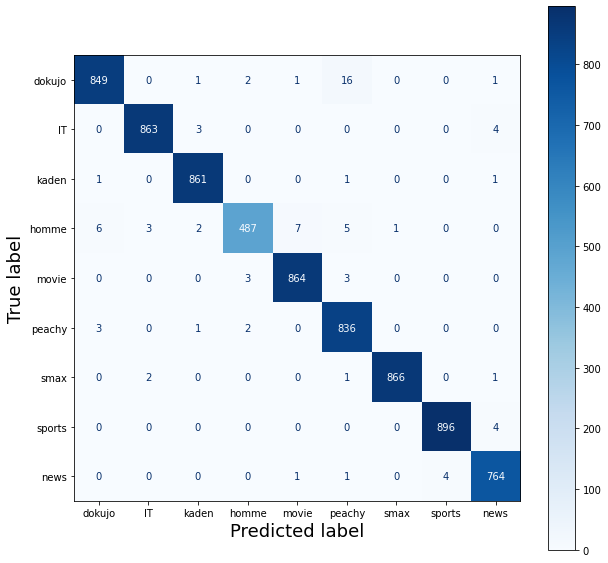

In [ ]:
cm = confusion_matrix(y_true=y_trues, y_pred=y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names).plot(cmap="Blues", values_format="d")

In [ ]:
os.makedirs("./result", exist_ok=True)
cm_display.figure_.savefig("./result/result_newsclassification.png", transparent=True, dpi=300, bbox_inches="tight", pad_inches=0.0)

In [ ]:
# 判断根拠の説明をするためのデモとして、test_sizeで指定した割合 or 数 だけ、テキストとラベルを抽出
_, examples = train_test_split(df, test_size=10, stratify=df["Label"])

In [ ]:
# クロスバリデーションの中で正答率が最も高かったときの識別器をattentionの可視化に利用
best_index = np.argmax(accuracy_scores)
best_model = estimators[best_index]

In [ ]:
# 判断根拠の説明を抽出した文章に対して行う
# 赤く示した箇所が、該当のラベルを判断するために重要だと判断した箇所 
best_model.visualize_attention(test_df=examples, categories=label_names)

[I 201102 07:57:22 <ipython-input-9-589a59641233>:314] Dataset and DataLoader from pandas dataframe has finished
[I 201102 07:57:22 <ipython-input-9-589a59641233>:320] 使用デバイス：cuda
[I 201102 07:57:22 <ipython-input-9-589a59641233>:321] -----Start Explanation-------
  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------Explanation Phase----------------------------

Creating dataset and dataloader from pandas dataframe


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


[I 201102 07:57:23 <ipython-input-9-589a59641233>:343] ------Finished Explanation------
